In [1]:
import mesa
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import requests
import os
import pickle

from mesa import Agent, Model
from mesa.time import RandomActivation # random order of agent actions
from mesa.space import MultiGrid # multiple agents er cell
from mesa.datacollection import DataCollector

(<Figure size 1500x600 with 2 Axes>,
 array([<Axes: title={'center': 'Provider Approaches by Type'}>,
        <Axes: title={'center': 'System Capacity and Care Delivery'}>],
       dtype=object))

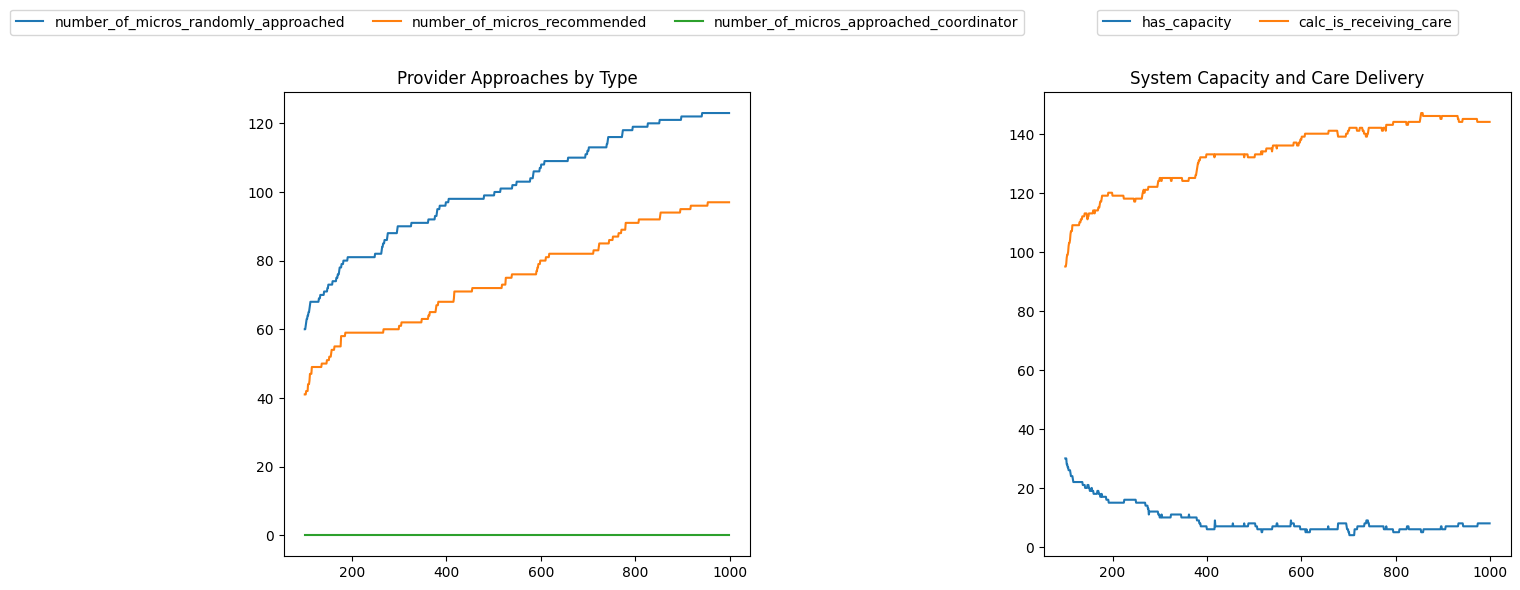

In [6]:
"""
==To-Do==

* refactor exercise

* STARTED differentiate contracting fucntion from randomly approaching a
  microprovider

* incorporating resident movement
  - how do resident's move around their enviornment
  - should they move randomly?
  - No idea really how this should work...

* rounding problem - you know what it is...

* Adding more detail into how micro-provider quality is generated
  how can micro-provider quality increase over time?

* Adding in more detail around how interventions might make a difference to
  micros

* Consider how this will be packaged in a dashboard for people to try.
 - streamlit

1/2* Adding in how microproviders can leave the model, how unpaid carers can
 leave the model
    
THOUGHTS:    

Inevitably out in the community residents needs will become too complex to be
safely delivered by a micro-provider.
Micros will deliver care when they really should be, sometimes...
Micros will recognise when they need to stop delivering care...
A way of warming the model, it all happens just at once at the moment.

potential interventions:
    Increasing the amount of people able to use micro-providers
    Increasing the amount of people able to use micro-providers safely
    Increasing the amount of micro-providers
"""

class Resident_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # residents unpaidcarers -- not used at the moment
        self.unpaidcarers = []
        # residents unpaidcare received -- not used at the moment
        self.unpaidcare_rec = []

        # residents microproviders
        self.microproviders = []

        # residents care received from microproviders
        self.packages_of_care_received = []

        # residents who have reviewed the care received by a micro and would 
        # promote them to other residents
        self.microproviders_to_recommend = []

        # residents who have attempted to contract a microprovider but have not 
        # met quality standard, therefore not contracted and not promoted
        self.blacklisted_microproviders = []

        # residents care needs met
        self.care_needs_met = False

        # initate residents care needs self.care_needs
        self.initiate_care_needs()

        # initiate micro quality threshold self.micro_quality_threshold
        self.initiate_micro_quality_threshold()

    # functions to initiate care needs
    def initiate_care_needs(self):
        self.generate_care_needs = round(np.random.normal(20,15),1)
        self.care_needs = self.generate_care_needs
        
    # function to initiate micro quality threshold
    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual_thrshld = round(random.uniform(0,1),3)
        self.micro_quality_threshold = self.generate_mic_qual_thrshld
    
    # function to decide if care needs are met
    def decide_needs_met(self):
        concat_list = self.packages_of_care_received + self.unpaidcare_rec
        if self.care_needs <= sum(concat_list):
            self.care_needs_met = True
        else:
            self.care_needs_met = False

    # randomly approaching a microprovider
    def contract_random_microprovider(self):
        """Attempt to contract with random provider."""
        if not self.model.microprovider_agent_registry:  # Check if any providers exist
            return False
            
        available_providers = [
            mp_id for mp_id in self.model.microprovider_agent_registry.keys()
            if mp_id not in self.blacklisted_microproviders
        ]
        
        if not available_providers:
            return False
            
        random_microprovider_id = random.choice(available_providers)
        random_microprovider = self.model.microprovider_agent_registry[
            random_microprovider_id]['agent_object']
        
        if self.contract_microprovider(random_microprovider_id, random_microprovider):
            self.model.num_micros_approached_randomly += 1
            return True
        return False
   
    # unpaidcarers recommending a microprovider to their assigned resident
    # this might not do anything at the moment -- not used at the moment
    def check_unpaidcarers_microproviders(self):
        """Check for and attempt to contract a microprovider recommended by unpaid carers.
        
        Gets recommendations from resident's unpaid carers and attempts to contract
        one of their recommended providers.
        
        Returns:
            bool: True if successfully contracted a microprovider, False otherwise
        """
        # Get all recommendations from unpaid carers
        carer_micro_list = self._get_carer_recommendations()
        
        # Filter out already contracted providers
        possible_micros = [
            mp for mp in carer_micro_list 
            if mp not in self.microproviders
        ]
        
        if not possible_micros:
            return False

        # Select and attempt to contract random recommended provider
        recommended_provider_id = random.choice(possible_micros)
        recommended_provider = self.model.microprovider_agent_registry[
            recommended_provider_id]['agent_object']
        
        if self.contract_microprovider(recommended_provider_id, recommended_provider):
            self.model.num_micros_approached_carer_recommended += 1
            return True
            
        return False

  # get carer recommendations -- not used at the moment
    def _get_carer_recommendations(self):
        carer_micro_list = []
        for carer_id in self.unpaidcarers:
            carer = self.model.unpaidcarer_agent_registry[carer_id]
            recommended_micros = carer['microproviders_to_recommend']
            if recommended_micros:
                carer_micro_list.extend(recommended_micros)
                
        return carer_micro_list

    # check a residents list of recommended microproviders.
    def check_recommended_microproviders(self):
        # Filter for recommended microproviders that still exist and aren't contracted
        possible_micros = [
            mp for mp in self.microproviders_to_recommend 
            if (mp not in self.microproviders and 
                mp in self.model.microprovider_agent_registry)
        ]
        
        if not possible_micros:
            # Clean up recommendations list by removing non-existent providers
            self.microproviders_to_recommend = [
                mp for mp in self.microproviders_to_recommend
                if mp in self.model.microprovider_agent_registry
            ]
            return False

        # Select and attempt to contract random recommended provider
        recommended_provider_id = random.choice(possible_micros)
        recommended_provider = self.model.microprovider_agent_registry[
            recommended_provider_id]['agent_object']
        
        if self.contract_microprovider(recommended_provider_id, recommended_provider):
            self.model.num_micros_approached_recommended += 1
            return True
            
        return False
    
    # checks if the model running with an active coordinator?
    def has_active_coordinator(self):
        if self.model.step_count < 0:  # Check step count
            return False
    
        return (self.model.num_coordinator_agents > 0 and 
                self.model.coordinator_agent_registry[0]\
                ['registered_microproviders'])

    # working with coordinator to find a microprovider
    def get_eligible_microproviders(self):
        eligible = []
        registered_providers = self.model.coordinator_agent_registry[0]\
        ['registered_microproviders']
        
        for micro_id in registered_providers:
            micro = self.model.microprovider_agent_registry[micro_id]\
            ['agent_object']
            if (micro.has_capacity and 
            micro.micro_quality >= self.micro_quality_threshold):
                eligible.append(micro_id)
                
        return eligible
    
    # resident finding a package of care through a coordinator
    def coord_care_brokerage(self):
        """Attempts to find and contract through coordinator."""
        if not self.has_active_coordinator():
            return False
            
        # Get only existing registered providers
        registered_providers = [
            mp for mp in self.model.coordinator_agent_registry[0]\
            ['registered_microproviders']\
            if mp in self.model.microprovider_agent_registry
        ]
        
        # Update coordinator registry to remove non-existent providers
        self.model.coordinator_agent_registry[0]\
        ['registered_microproviders'] = registered_providers
        
        eligible_microproviders = []
        for micro_id in registered_providers:
            micro = self.model.microprovider_agent_registry[micro_id]\
            ['agent_object']
            if (micro.has_capacity and 
            micro.micro_quality >= self.micro_quality_threshold):
                eligible_microproviders.append(micro_id)
                
        if not eligible_microproviders:
            return False
            
        if self.attempt_contract_with_eligible(eligible_microproviders):
            self.model.num_micros_approached_coordinator += 1
            return True
        return False
    
    # attempt to contract with a microprovider based on functions above if there
    # is more than one potential microprovider (i.e., not approaching one
    # randomly)
    def attempt_contract_with_eligible(self, eligible_microproviders):
        random.shuffle(eligible_microproviders)
        
        for micro_id in eligible_microproviders:
            micro = self.model.microprovider_agent_registry[micro_id]\
            ['agent_object']
            if self.contract_microprovider(micro_id, micro):
                return True
                
        return False

    # function for actually contracting the microprovider (used inside of 
    # attempt to contract with eligible micro_provider)
    def contract_microprovider(self, micro_id, micro_provider):
        # Early returns for invalid conditions
        if micro_id in self.blacklisted_microproviders:
            return False
            
        if micro_provider.micro_quality < self.micro_quality_threshold:
            return False
            
        if not micro_provider.has_capacity:
            return False
            
        if micro_id in self.microproviders:
            return False
            
        # Calculate care package size
        care_delivered = self._calculate_care_package(micro_id)
        
        self._update_resident_records(micro_provider, care_delivered)
        
        self._update_microprovider_records(micro_provider, care_delivered)
        
        return True

    # function used in contract_microprovider to calculate the care package
    def _calculate_care_package(self, micro_id):
        max_capacity = self.model.microprovider_agent_registry[micro_id]\
        ['agent_care_capacity']

        return round(random.uniform(1, max_capacity), 1)

    # function to update resident records after contracting a microprovider
    def _update_resident_records(self, micro_provider, care_delivered):
        self.microproviders.append(micro_provider.unique_id)
        self.packages_of_care_received.append(care_delivered)
        self.decide_needs_met()

    # function to update microprovider records after contracting a microprovider
    def _update_microprovider_records(self, micro_provider, care_delivered):
        micro_provider.residents.append(self.unique_id)
        micro_provider.packages_of_care.append(care_delivered)
        micro_provider.decide_capacity()
    
    # process for reviewing care received from microproviders -- how residents
    # come to influence the microprovider market
    def review_care_received(self):
        for index, micro in enumerate(self.microproviders):
            if not random.choice([True, False]):  # Skip review with 50% chance
                continue
            
            micro_object = self.model.microprovider_agent_registry[micro]['agent_object']
            
            if self._is_satisfied_with_care(micro_object):
                self._handle_satisfactory_care(micro)
            else:
                self._handle_unsatisfactory_care(index, micro, micro_object)

    def _is_satisfied_with_care(self, micro_object):
        return self.micro_quality_threshold <= micro_object.micro_quality

    def _handle_satisfactory_care(self, micro):
        if random.choice([True, False]) and\
        micro not in self.microproviders_to_recommend:
            self.microproviders_to_recommend.append(micro)

    def _handle_unsatisfactory_care(self, index, micro, micro_object):
        """Handles case where resident is unsatisfied with care.
        
        Removes care relationship and updates all relevant records.
        
        Args:
            index: Index of microprovider in resident's lists
            micro: ID of microprovider being reviewed
            micro_object: MicroProvider_Agent object
        """
        # Update resident records
        self.blacklisted_microproviders.append(micro)
        pckg_t_rmv = self.packages_of_care_received[index]
        self.packages_of_care_received.remove(pckg_t_rmv)
        self.microproviders.remove(micro)
        
        if micro in self.microproviders_to_recommend:
            self.microproviders_to_recommend.remove(micro)

        # Update microprovider records
        resi_index = micro_object.residents.index(self.unique_id)
        resi_package = micro_object.packages_of_care[resi_index]
        micro_object.residents.remove(self.unique_id)
        micro_object.packages_of_care.remove(resi_package)

    def promote_microprovider(self):
        """
        Promote recommended microproviders to nearby residents.
        
        Finds nearby residents in the same cell and shares microprovider 
        recommendations with them if they haven't blacklisted those providers.
        """
        # Get nearby residents
        nearby_residents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        
        # Filter for resident agents
        for inhabitant in cellmates:
            if isinstance(inhabitant, Resident_Agent) and inhabitant != self:
                nearby_residents.append(inhabitant)
        
        if not nearby_residents or not self.microproviders_to_recommend:
            return
            
        # Choose a random resident to share recommendations with
        resident_to_chat = random.choice(nearby_residents)
        
        # Share recommendations
        for micro in self.microproviders_to_recommend:
            if (micro not in resident_to_chat.microproviders_to_recommend and 
                micro not in resident_to_chat.blacklisted_microproviders):
                resident_to_chat.microproviders_to_recommend.append(micro)
                
    def decide_to_leave(self):
        """Decide if resident should leave the model (needs met for long time)."""
        if self.care_needs_met and random.random() < 0.001:  # 0.1% chance if needs met
            self.model.remove_agent(self)
            return True
        return False
   
    def _try_find_care(self):
            """Attempt to find care through various channels in priority order.
            
            Returns:
                bool: True if care was found, False otherwise
            """
            # Try recommended providers first
            if self.microproviders_to_recommend:
                # print(f"Agent {self.unique_id} has recommendations: {self.microproviders_to_recommend}")
                if self.check_recommended_microproviders():
                    # print(f"Agent {self.unique_id} successfully contracted recommended provider")
                    return True
                # print(f"Agent {self.unique_id} has no recommendations")
                
            # Try unpaid carer recommendations next
            if self.check_unpaidcarers_microproviders():
                return True
                
            # Small chance to use coordinator
            if random.random() < 0.005:
                if self.coord_care_brokerage():
                    return True
            # Otherwise try random provider
            elif random.random() < 0.001:
                if self.contract_random_microprovider():
                    return True
                    
            return False

    def _periodic_care_review(self):
        """Periodically review and promote care arrangements."""
        # 5% chance to review current care
        if random.random() < 0.8:
            self.review_care_received()
        
        # 5% chance to promote providers
        if random.random() < 0.5:
            self.promote_microprovider()

    def step(self):
        if self.decide_to_leave():
            return
        
        self.decide_needs_met()
        
        if not self.care_needs_met:
            if self._try_find_care():
                return
                
        self._periodic_care_review()

 #MicroProvider Agent   
class MicroProvider_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.packages_of_care = []
        self.has_capacity = True
        self.initiate_care_capacity()
        self.initiate_micro_quality_threshold()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(10,50),1)
        self.care_capacity = self.generate_care_capacity

    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual = round(random.uniform(0,1),3)
        self.micro_quality = self.generate_mic_qual

    def decide_capacity(self):
        if sum(self.packages_of_care) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def register_with_coordinator(self):
        """Attempt to register microprovider with coordinator if eligible.
        
        Registers with coordinator if:
        1. Coordinator exists
        2. Not already registered
        3. Has at least one resident
        4. Meets quality threshold
        """
        if not self.model.num_coordinator_agents:
            return
            
        coordinator_registry = self.model.coordinator_agent_registry[0]
        
        if (self.unique_id not in coordinator_registry\
        ['registered_microproviders'] and len(self.residents) >= 1 and
        self.micro_quality >= coordinator_registry['micro_quality_threshold']):
            
            coordinator_registry['registered_microproviders'].append(self.unique_id)

    def decide_to_leave(self):
        """Decide if microprovider should leave the model (no residents for long time)."""
        if not self.residents and random.random() < 0.002:  # 0.2% chance if no residents
            self.model.remove_agent(self)
            return True
        return False
    
    def step(self):
        if self.decide_to_leave():
            return

        self.decide_capacity()

        if model.num_coordinator_agents > 0 and\
            self.unique_id not in model.coordinator_agent_registry[0]['registered_microproviders']:
            if random.random() < 0.5:
                self.register_with_coordinator()

'''
Unpaid Care Agent not used
'''
class UnpaidCare_Agent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.unpaidcare_delivered = []
        self.microproviders_to_recommend = []
        self.blacklisted_microproviders = []
        self.has_capacity = True
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def decide_capacity(self):
        if sum(self.unpaidcare_delivered) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def locate_resident(self):
        """Attempt to find and provide care to a random resident.
        
        Selects a random resident and if the carer has capacity and isn't already 
        caring for them, establishes a care relationship.
        """
        # Select random resident
        allocated_resident_id = random.choice(
            list(self.model.resident_agent_registry.keys())
        )
        
        allocated_resident = self.model.resident_agent_registry[
            allocated_resident_id]['agent_object']

        # Check if can provide care
        if not (self.has_capacity and 
                self.unique_id not in allocated_resident.unpaidcarers):
            return
            
        # Calculate care amount
        care_delivered = round(
            random.uniform(1, self.care_capacity),
            1
        )
        
        # Update carer records
        self._update_carer_records(allocated_resident.unique_id, care_delivered)
        
        # Update resident records
        self._update_resident_records(allocated_resident, care_delivered)

    def _update_carer_records(self, resident_id, care_delivered):
        """Update carer's records with new care arrangement.
        
        Args:
            resident_id: ID of resident receiving care
            care_delivered: Amount of care to be delivered
        """
        self.residents.append(resident_id)
        self.unpaidcare_delivered.append(care_delivered)
        self.decide_capacity()

    def _update_resident_records(self, resident, care_delivered):
        """Update resident's records with new care arrangement.
        
        Args:
            resident: Resident_Agent object receiving care
            care_delivered: Amount of care to be delivered
        """
        resident.unpaidcarers.append(self.unique_id)
        resident.unpaidcare_rec.append(care_delivered)
        resident.decide_needs_met()

    def fetch_microproviders(self):
        if len(self.residents) > 0:
            for resident_id in self.residents:
                resident_object = self.model.resident_agent_registry\
                    [resident_id]['agent_object']
                
                # Get the microproviders this resident recommends
                resident_recommended_microproviders = resident_object\
                    .microproviders_to_recommend
                
                # Add recommended microproviders to unpaid carer's list
                # if not already there
                for micro_id in resident_recommended_microproviders:
                    if micro_id not in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.append(micro_id)

    def promote_microprovider(self):
        """Promote recommended microproviders to nearby agents.
        
        Finds nearby residents and unpaid carers in the same cell and shares 
        microprovider recommendations with them if they haven't blacklisted 
        those providers.
        """
        # Get nearby agents that can receive recommendations
        nearby_agents = self._get_nearby_recommendation_targets()
        
        if not nearby_agents or not self.microproviders_to_recommend:
            return
            
        # Choose a random agent to share recommendations with
        target_agent = random.choice(nearby_agents)
        
        # Share recommendations
        self._share_recommendations(target_agent)

    def _get_nearby_recommendation_targets(self):
        """Get list of nearby agents that can receive recommendations.
        
        Returns:
            list: Agents in same cell that can receive recommendations
        """
        nearby_agents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        
        for inhabitant in cellmates:
            if isinstance(inhabitant, (Resident_Agent, UnpaidCare_Agent)):
                nearby_agents.append(inhabitant)
                
        return nearby_agents

    def _share_recommendations(self, target_agent):
        """Share microprovider recommendations with target agent.
        
        Args:
            target_agent: Agent to receive recommendations
        """
        for micro in self.microproviders_to_recommend:
            if self._can_recommend_to_agent(micro, target_agent):
                target_agent.microproviders_to_recommend.append(micro)

    def _can_recommend_to_agent(self, micro, agent):
        """Check if microprovider can be recommended to agent.
        
        Args:
            micro: ID of microprovider to recommend
            agent: Agent to receive recommendation
            
        Returns:
            bool: True if provider can be recommended, False otherwise
        """
        return (micro not in agent.microproviders_to_recommend and
                micro not in agent.blacklisted_microproviders)
    
    def step(self):
        if self.has_capacity:
            self.locate_resident()
        self.fetch_microproviders()

        if random.choice([True, False]):
            self.promote_microprovider()

class Coordinator_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.registered_microproviders = []
        self.micro_quality_threshold = 0.5

    def step(self):
        pass

class Care_Model(Model):
    # constructor
    def __init__(self,
                N_RESIDENT_AGENTS,
                N_MICROPROVIDER_AGENTS,
                N_UNPAIDCARE_AGENTS,
                N_COORDINATOR_AGENTS,
                width,
                height
                ):
        super().__init__()

        # models own variables
        self.num_resident_agents = N_RESIDENT_AGENTS
        self.num_microprovider_agents = N_MICROPROVIDER_AGENTS
        self.num_unpaidcare_agents = N_UNPAIDCARE_AGENTS
        self.num_coordinator_agents = N_COORDINATOR_AGENTS
        self.running = True
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.step_count = 0

        # counter of number of micros approached any what way
        self.num_micros_approached_randomly = 0
        self.num_micros_approached_recommended = 0
        self.num_micros_approached_carer_recommended = 0
        self.num_micros_approached_coordinator = 0

        # agent registries
        self.resident_agent_registry = {}
        self.microprovider_agent_registry = {}
        self.unpaidcarer_agent_registry = {}
        self.coordinator_agent_registry = {}

        # adding resident agents
        for i in range(self.num_resident_agents):
            a = Resident_Agent(i, self)
            self.schedule.add(a)
            self.resident_agent_registry[i] = {
                'agent_object' : a,
                'agent_id': i,
                'care_needs_met': False,
                'agent_care_needs': a.care_needs,
                'micro_quality_threshold': a.micro_quality_threshold,
                'allocated_microproviders': [],
                'packages_of_care_received': [],
                'microproviders_to_recommend': [],
                'blacklisted_microproviders': [],
                'unpaidcarers': [],
                'unpaidcare_rec': []
            }
           
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
            # print(f'placed resident agent {a.pos}')

        # adding micro-provider agents
        for i in range(self.num_microprovider_agents):
            a = MicroProvider_Agent(i, self)
            self.schedule.add(a)
            self.microprovider_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity' : a.care_capacity,
                'micro_quality': a.micro_quality,
                'has_capacity': True,
                'allocated_residents': [],
                'packages_of_care_delivered': []
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
         
        # adding unpaid carer agents
        for i in range(self.num_unpaidcare_agents):
            a = UnpaidCare_Agent(i, self)
            self.schedule.add(a)
            self.unpaidcarer_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity': a.generate_care_capacity,
                'has_capacity': a.has_capacity,
                'residents': [],
                'unpaidcare_delivered': [],
                'microproviders_to_recommend': []
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))

        # adding coordinator agents
        for i in range(self.num_coordinator_agents):
            a = Coordinator_Agent(i, self)
            self.schedule.add(a)
            self.coordinator_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'registered_microproviders': [],
                'micro_quality_threshold': a.micro_quality_threshold
            }

        self.datacollector = DataCollector(
            model_reporters={
                    "calc_allocated_residents":
                    self.calc_allocated_residents,
                    "calc_resident_packages":
                    self.calc_packages_of_care_delivered,
                    "calc_capacity":
                    self.calc_micro_capacity,
                    "has_capacity":
                    self.micro_has_capacity,
                    "number_of_micros_randomly_approached":
                    self.calc_num_micros_approached_randomly,
                    "number_of_micros_recommended":
                    self.calc_num_micros_approached_recommended,
                    "number_of_micros_carer_recommended":
                    self.calc_num_micros_approached_carer_recommended,
                    "number_of_micros_approached_coordinator":
                    self.calc_num_micros_approached_coordinator,
                    "calc_is_receiving_care":
                    self.calc_receiving_care,}
        )

                # # adding datacollector to model
        # self.datacollector = DataCollector(
        #     model_reporters={
        #             "calc_allocated_residents":
        #             self.calc_allocated_residents,
        #             "calc_resident_packages":
        #             self.calc_packages_of_care_delivered,
        #             "calc_capacity":
        #             self.calc_micro_capacity,
        #             "has_capacity":
        #             self.micro_has_capacity,
        #             "calc_unpaidcare_received": 
        #             self.calc_unpaidcare_received,
        #             "calc_care_received":
        #             self.calc_care_received,
        #             "calc_care_needs":
        #             self.calc_care_needs,
        #             "calc_is_receiving_care":
        #             self.calc_receiving_care,
        #             "number_of_micros_randomly_approached":
        #             self.calc_num_micros_approached_randomly,
        #             "number_of_micros_recommended":
        #             self.calc_num_micros_approached_recommended,
        #             "number_of_micros_carer_recommended":
        #             self.calc_num_micros_approached_carer_recommended,
        #             "number_of_micros_approached_coordinator":
        #             self.calc_num_micros_approached_coordinator
        #         }
            # )

    def add_new_agents(self):
        """
        Add new agents to the model with small random chance.
        """
        # Chance for new resident to join
        if random.random() < 0.01:
            new_id = max(self.resident_agent_registry.keys()) + 1
            self._add_new_resident(new_id)
            
        # Chance for new microprovider to join    
        if random.random() < 0.002:
            new_id = max(self.microprovider_agent_registry.keys()) + 1
            self._add_new_microprovider(new_id)

    def _add_new_resident(self, new_id):
        a = Resident_Agent(new_id, self)
        self.schedule.add(a)
        self.resident_agent_registry[new_id] = {
            'agent_object': a,
            'agent_id': new_id,
            'care_needs_met': False,
            'agent_care_needs': a.care_needs,
            'micro_quality_threshold': a.micro_quality_threshold,
            'allocated_microproviders': [],
            'packages_of_care_received': [],
            'microproviders_to_recommend': [],
            'blacklisted_microproviders': [],
            'unpaidcarers': [],
            'unpaidcare_rec': []
        }
        
        try:
            start_cell = self.grid.find_empty()
            self.grid.place_agent(a, start_cell)
        except:
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
        
        self.num_resident_agents += 1

    def _add_new_microprovider(self, new_id):
        a = MicroProvider_Agent(new_id, self)
        self.schedule.add(a)
        self.microprovider_agent_registry[new_id] = {
            'agent_object': a,
            'agent_id': new_id,
            'agent_care_capacity': a.care_capacity,
            'micro_quality': a.micro_quality,
            'has_capacity': True,
            'allocated_residents': [],
            'packages_of_care_delivered': []
        }
        
        try:
            start_cell = self.grid.find_empty()
            self.grid.place_agent(a, start_cell)
        except:
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
        self.num_microprovider_agents += 1
            
    #model functions
    def calc_num_micros_approached_randomly(self):
        num = self.num_micros_approached_randomly
        return num
    
    def calc_num_micros_approached_recommended(self):
        num = self.num_micros_approached_recommended
        return num
    
    def calc_num_micros_approached_carer_recommended(self):
        num = self.num_micros_approached_carer_recommended
        return num
    
    def calc_num_micros_approached_coordinator(self):
        num = self.num_micros_approached_coordinator
        return num
    
    #microprovider functions
    def calc_allocated_residents(self):
        allocated_residents_total = []
        # Iterate through existing agents only
        for agent_id in self.microprovider_agent_registry:
            allocated_residents = self.microprovider_agent_registry[agent_id]['allocated_residents']
            if allocated_residents:
                allocated_residents_total.extend(allocated_residents)
        return len(allocated_residents_total)
    
    def calc_packages_of_care_delivered(self):
        packages_of_care_total = []
        # Iterate through existing agents only
        for agent_id in self.microprovider_agent_registry:
            packages_of_care = self.microprovider_agent_registry[agent_id]['packages_of_care_delivered']
            if packages_of_care:
                packages_of_care_total.extend(packages_of_care)
        return sum(packages_of_care_total)

    def calc_micro_capacity(self):
        total_care_capacity = []
        # Iterate through existing agents only
        for agent_id in self.microprovider_agent_registry:
            care_capacity = self.microprovider_agent_registry[agent_id]['agent_care_capacity']
            total_care_capacity.append(care_capacity)
        return sum(total_care_capacity)

    def micro_has_capacity(self):
        has_capacity = []
    # Iterate through existing agents only
        for agent_id in self.microprovider_agent_registry:
            if self.microprovider_agent_registry[agent_id]['has_capacity']:
                has_capacity.append(agent_id)
        return len(has_capacity)

    #resident functions
    # def calc_blacklisted_microproviders(self):
    #     total_blacklisted_microproviders = []
    #     for x in range(len(model.resident_agent_registry)):
    #         blacklisted_microproviders = model.resident_agent_registry[x]\
    #             ['blacklisted_microproviders']
    #         if blacklisted_microproviders != None:
    #             total_blacklisted_microproviders.extend\
    #                 (blacklisted_microproviders)
    #         else:
    #             pass
    #     return len(total_blacklisted_microproviders)

    # def calc_unpaidcare_received(self):
    #     total_unpaidcare_delivered = []
    #     for x in range(len(model.resident_agent_registry)):
    #         unpaidcare_delivered =model.resident_agent_registry[x]\
    #             ['unpaidcare_rec']
    #         if unpaidcare_delivered != None:
    #             total_unpaidcare_delivered.extend(model.resident_agent_registry[x]\
    #             ['unpaidcare_rec'])
    #     return sum(total_unpaidcare_delivered)

    def calc_receiving_care(self):
        count_receiving_care = 0
        for agent_id in self.resident_agent_registry:
            if self.resident_agent_registry[agent_id]['packages_of_care_received'] != []:
                count_receiving_care += 1
        return count_receiving_care

    # # should this also include unpaid care??
    # def calc_care_received(self):
    #     total_care_received = []
    #     for x in range(len(model.resident_agent_registry)):
    #         care_received = model.resident_agent_registry[x]\
    #         ['packages_of_care_received']
    #         # print(care_received)
    #         if care_received != None:
    #             total_care_received.extend(care_received)
    #     return sum(total_care_received)

    # def calc_care_needs(self):
    #     total_care_needs = []
    #     for x in range(len(model.resident_agent_registry)):
    #         care_needs = (model.resident_agent_registry[x]\
    #         ['agent_care_needs'])
    #         total_care_needs.append(care_needs)
    #     return sum(total_care_needs)

    # model step
    def step(self):
        self.datacollector.collect(self)
        self.step_count += 1
        self.add_new_agents()
        
        # Update registries and step each agent
        for agent in self.schedule.agents:
            self._update_agent_registry(agent)
            agent.step()
            
        self.schedule.step() 

    def remove_agent(self, agent): 
        self.schedule.remove(agent)
        self.grid.remove_agent(agent)
        
        # Update registries based on agent type
        if isinstance(agent, Resident_Agent):
            # Remove resident from all microproviders
            for micro_id in agent.microproviders:
                micro = self.microprovider_agent_registry[micro_id]['agent_object']
                if agent.unique_id in micro.residents:
                    idx = micro.residents.index(agent.unique_id)
                    micro.residents.remove(agent.unique_id)
                    micro.packages_of_care.pop(idx)
                    micro.decide_capacity()
                    
            # Remove from registry
            del self.resident_agent_registry[agent.unique_id]
            self.num_resident_agents -= 1
            
        elif isinstance(agent, MicroProvider_Agent):
            # Remove microprovider from all residents
            for resident_id in agent.residents:
                resident = self.resident_agent_registry[resident_id]['agent_object']
                if agent.unique_id in resident.microproviders:
                    idx = resident.microproviders.index(agent.unique_id)
                    resident.microproviders.remove(agent.unique_id)
                    resident.packages_of_care_received.pop(idx)
                    resident.decide_needs_met()
                    
            # Remove from coordinator if registered
            if self.num_coordinator_agents > 0:
                if agent.unique_id in self.coordinator_agent_registry[0]['registered_microproviders']:
                    self.coordinator_agent_registry[0]['registered_microproviders'].remove(agent.unique_id)
                    
            # Remove from registry
            del self.microprovider_agent_registry[agent.unique_id]
            self.num_microprovider_agents -= 1

    def _update_agent_registry(self, agent):
        """Update the appropriate registry based on agent type."""
        if isinstance(agent, MicroProvider_Agent):
            self._update_microprovider_registry(agent)
        elif isinstance(agent, Resident_Agent):
            self._update_resident_registry(agent)
        elif isinstance(agent, UnpaidCare_Agent):
            self._update_unpaidcarer_registry(agent)
        elif isinstance(agent, Coordinator_Agent):
            self._update_coordinator_registry(agent)

    def _update_microprovider_registry(self, agent):
        """Update microprovider registry with current agent state."""
        registry = self.microprovider_agent_registry[agent.unique_id]
        registry.update({
            'allocated_residents': agent.residents,
            'packages_of_care_delivered': agent.packages_of_care,
            'has_capacity': agent.has_capacity
        })

    def _update_resident_registry(self, agent):
        """Update resident registry with current agent state."""
        registry = self.resident_agent_registry[agent.unique_id]
        registry.update({
            'allocated_microproviders': agent.microproviders,
            'packages_of_care_received': agent.packages_of_care_received,
            'care_needs_met': agent.care_needs_met,
            'blacklisted_microproviders': agent.blacklisted_microproviders,
            'microproviders_to_recommend': agent.microproviders_to_recommend,
            'unpaidcarers': agent.unpaidcarers,
            'unpaidcare_rec': agent.unpaidcare_rec
        })

    def _update_unpaidcarer_registry(self, agent):
        """Update unpaid carer registry with current agent state."""
        registry = self.unpaidcarer_agent_registry[agent.unique_id]
        registry.update({
            'residents': agent.residents,
            'unpaidcare_delivered': agent.unpaidcare_delivered,
            'has_capacity': agent.has_capacity,
            'microproviders_to_recommend': agent.microproviders_to_recommend
        })

    def _update_coordinator_registry(self, agent):
        """Update coordinator registry with current agent state."""
        registry = self.coordinator_agent_registry[agent.unique_id]
        registry.update({
            'registered_microproviders': agent.registered_microproviders
        })

#Set the parameters for your model
N_RESIDENT_AGENTS = 1000
N_MICROPROVIDER_AGENTS = 80
N_UNPAIDCARE_AGENTS = 0
N_COORDINATOR_AGENTS = 0
width = 20
height = 20

model = Care_Model(
    N_RESIDENT_AGENTS,
    N_MICROPROVIDER_AGENTS,
    N_UNPAIDCARE_AGENTS,
    N_COORDINATOR_AGENTS,
    width, 
    height)

# Run the model for a certain number of steps
num_steps = 1000
for i in range(num_steps):
    # print(i)
    model.step()

data = model.datacollector.get_model_vars_dataframe()
data = data.iloc[100:]

import pprint

pp = pprint.PrettyPrinter(indent=4, width =120)

# print(model.resident_agent_registry)
# print(model.microprovider_agent_registry)
# print(model.num_micros_approached_coordinator)
# print(model.num_micros_approached_recommended)
# print("\nResident Agent Registry:")
# pp.pprint(model.resident_agent_registry)

# print("\nMicroprovider Agent Registry:")
# pp.pprint(model.microprovider_agent_registry) 

# print("\nUnpaid Carer Agent Registry:")
# pp.pprint(model.unpaidcarer_agent_registry)

# print("\nCoordinator Agent Registry:")
# pp.pprint(model.coordinator_agent_registry) 

def plot(data):
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    data.plot(kind='line', y='number_of_micros_randomly_approached',ax=ax[0])
    data.plot(kind='line', y='number_of_micros_recommended',ax=ax[0])
    data.plot(kind='line', y='number_of_micros_approached_coordinator',ax=ax[0])
    data.plot(kind='line', y='has_capacity', ax=ax[1])
    data.plot(kind='line', y='calc_is_receiving_care', ax=ax[1])

    ax[0].legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=3)
    ax[1].legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=2)

    ax[0].set_title('Provider Approaches by Type')
    ax[1].set_title('System Capacity and Care Delivery')

    plt.tight_layout()
    # data.plot(kind='line', y='calc_blacklisted_microproviders', ax=ax[1])

    # data.plot(kind='line', y='number_of_micros_carer_recommended', ax=ax[1])
    return fig, ax

plot(data)